# Supplementary Figure 15: Very eakly informative prior, hail function

The ten different prior hail functions when the very weakly informative prior was applied to the Yeo-Johnson transform parameters.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(bayesplot, lib.loc = additional_package_lib)
  library(posterior, lib.loc = additional_package_lib)
  library(janitor, lib.loc = additional_package_lib)
  library(latex2exp, lib.loc = additional_package_lib)
  library(patchwork)
  library(scico)
})

# adding the pacakge lib to path - rstsan is finicky
.libPaths(c(additional_package_lib, .libPaths()))

suppressPackageStartupMessages({
  library(rstan, lib.loc = additional_package_lib)
})

# rstan options
options(mc.cores = min(8, parallel::detectCores()))
rstan_options(auto_write = TRUE)

In [2]:
inv_logit <- function(x){
  # The inverse logit or sigmoid function, used often in calculating probabilities
  #
  # Inputs:
  #  x  numeric, can be a vector
  #
  # Outputs:
  #  _  same shape as input, will be in (0, 1)

  1 / (1 + exp(-x))
}

yeo_johnson <- function(x, lambda) {
  # Yeo-Johnson transform of x using parameter lambda
  # Note the modification to improve vectorisation - only positive cases included
  #
  # Inputs:
  #  x       numeric >= 0
  #          the numeric (vector) to be transformed
  #  lambda  numeric
  #          real parameter defining the transform
  # 
  # Outputs:
  #  _       numeric
  #          transformed vector same shape as x
    
  eps <- 1e-5
  if (abs(lambda) < eps){
    log1p(x)
  } else {
    (((x + 1.0) ^ lambda) - 1.0) / lambda
  }
}

In [3]:
generate_prior_samples <- function(par1, par2, par3, var){
  # Given prior samples of the three parameters of the hail or reporting function
  # generate prior samples of the corresponsing function itself
  #
  # Inputs:
  #  par1  vector
  #        samples of the location parameter
  #  par2  vector
  #        samples of the slope parameter
  #  par3  vector
  #        samples of the Yeo-Johnson transform parameter
  #  var   str
  #        variable of interest (hail or report)
  # 
  # Outputs:
  #  _     tibble
  #        column to plot and then seven columns with quantiles
  #        for credible intervals
    
  # create vector of values at which to calculate for plot
  if (var == "hail") {
    x_plot <- seq(min(model_data$mesh), max(model_data$mesh), length.out = 100)
  } else {
    # population density is equally spaced on log scale
    x_plot <- exp(seq(log(min(model_data$pop_dens)), log(max(model_data$pop_dens)), length.out = 100))
  }
    
  # pre allocating for function results
  mat_func <- matrix(0, nrow = length(x_plot ), ncol = length(par1))
    
  for (i in 1:length(par3)) {
    # calculate the transform for each prior sample for x to plot
    #x_plot_trans <- map_dbl(x_plot, \(y) yeo_johnson(y, par3[i])) # TODO:DELETE?
    x_plot_trans <- yeo_johnson(x_plot, par3[i])
      
    # need to apply also to all data so we can standardise appropriately
    if (var == "hail"){
      all_x_trans <- yeo_johnson(model_data$mesh, par3[i])
    } else {
      all_x_trans <- yeo_johnson(model_data$pop_dens, par3[i])
    }
    # standardising the plotting variable
    x_plot_trans_std <- (x_plot_trans - mean(all_x_trans)) / sd(all_x_trans)
      
    # calculating the relevant probability
    mat_func[, i] <- inv_logit(par1[i] + par2[i] * x_plot_trans_std) 
  }
    
  # summarise the draws via quantile function
  apply(mat_func, MARGIN = 1, FUN = quantile, probs = c(0.005, 0.025, 0.25, 0.75, 0.975, 0.995)) %>%
    t() %>%
    cbind(true_x = x_plot) %>%
    as_tibble(.name_repair = make_clean_names) 
}

Sampling from the filtered priors is challenging and is done using stan.
The script is modified from the actual model script to sample from the priors.

In [4]:
stan_string <- '
// Testing new set up

functions {
  // implements the yeo_johnson transform 
  real yeo_johnson(real x, real lambda){
    real eps = 1e-5;
    if (x >= 0.0){
      if (abs(lambda) < eps) {
        return log1p(x);
      } else {
        return (((x + 1.0) .^ lambda) - 1.0) ./ lambda;
      }
    } else {
      if (abs(lambda - 2.0) < eps) {
        return -log1p(-x);
      } else {
        return -(((-x + 1.0) .^ (2.0 - lambda)) - 1.0) ./ (2.0 - lambda);
      }
    }
  }

  // implements inverse yeo johnson transform
  real inv_yeo_johnson(real x, real lambda){
    real eps = 1e-5;
    if (x >= 0.0){
      if (abs(lambda) < eps) {
        return exp(x) - 1.0;
      } else {
        return ((x * lambda + 1.0) .^ (1.0 / lambda)) - 1.0;
      }
    } else {
      if (abs(lambda - 2.0) < eps) {
        return 1.0 - exp(-x);
      } else {
        return 1.0 - ((x * (lambda - 2.0) + 1.0) .^ (1.0 / (2.0 - lambda)));
      }
    }
  }
}
// input data
data {
  int<lower=0> N_train;
  int<lower=0> N_test;
  matrix[N_train, 2] X_mesh_train;
  matrix[N_test, 2] X_mesh_test;
  matrix[N_train, 2] X_report_train;
  matrix[N_test, 2] X_report_test;
  vector[3] beta_hail_lower_bounds;
  vector[3] beta_report_lower_bounds;
  int<lower=0, upper=1> filter_prob;
  int<lower=0, upper=1> filter_number;
  vector[2] beta_hail3_params;
  vector[2] beta_report3_params;
}
// parameters
parameters {
  vector<lower=beta_hail_lower_bounds>[3] beta_hail_raw;
  vector<lower=beta_report_lower_bounds>[3] beta_report_raw;
}
// transformed parameters
transformed parameters {
  // unstandardised parameters
  vector[3] beta_hail;
  vector[3] beta_report;
  real<lower=0> mesh_at_prob_0p5;
  real<lower=0, upper=N_train> expected_total_hail_events_train;

  // standardised and transformed matrices
  matrix[N_train, 2] X_mesh_train_std_trans;
  matrix[N_test, 2] X_mesh_test_std_trans;
  matrix[N_train, 2] X_report_train_std_trans;
  matrix[N_test, 2] X_report_test_std_trans;

  // probability of report
  vector<lower=0, upper=1>[N_train] prob_report_train;
  
  // Yeo-Johnson transformed variables
  vector[N_train] mesh_train_yj;
  vector[N_test] mesh_test_yj;
  vector[N_train] dens_train_yj;
  vector[N_test] dens_test_yj;

  // applying transform
  for (i in 1:N_train) {
    mesh_train_yj[i] = yeo_johnson(X_mesh_train[i, 2], beta_hail_raw[3]);
    dens_train_yj[i] = yeo_johnson(X_report_train[i, 2], beta_report_raw[3]);
  }
  for (i in 1:N_test) {
    mesh_test_yj[i] = yeo_johnson(X_mesh_test[i, 2], beta_hail_raw[3]);
    dens_test_yj[i] = yeo_johnson(X_report_test[i, 2], beta_report_raw[3]);
  }
  
  // calculating statistics
  real mesh_train_yj_mean = mean(mesh_train_yj);
  real mesh_train_yj_sd = sd(mesh_train_yj);
  real dens_train_yj_mean = mean(dens_train_yj);
  real dens_train_yj_sd = sd(dens_train_yj);  

  // making transformed and normalised matrics
  X_mesh_train_std_trans[, 1] = X_mesh_train[, 1];
  X_mesh_train_std_trans[, 2] = (mesh_train_yj - mesh_train_yj_mean) / mesh_train_yj_sd;

  X_mesh_test_std_trans[, 1] = X_mesh_test[, 1];
  X_mesh_test_std_trans[, 2] = (mesh_test_yj - mesh_train_yj_mean) / mesh_train_yj_sd;

  X_report_train_std_trans[, 1] = X_report_train[, 1];
  X_report_train_std_trans[, 2] = (dens_train_yj - dens_train_yj_mean) / dens_train_yj_sd;

  X_report_test_std_trans[, 1] = X_report_test[, 1];
  X_report_test_std_trans[, 2] = (dens_test_yj - dens_train_yj_mean) / dens_train_yj_sd;
  {
    // cant have constraints in these local blocks
    // note the yj parameter is in the last entry of beta_hail
    vector[N_train] prob_hail_train = inv_logit(X_mesh_train_std_trans * beta_hail_raw[1:2]);
    vector[N_train] prob_report_given_hail_train = inv_logit(X_report_train_std_trans * beta_report_raw[1:2]);
    prob_report_train = prob_hail_train .* prob_report_given_hail_train;
    expected_total_hail_events_train = sum(prob_hail_train);
  }

  // unstandardised parameters  
  beta_report[1] = beta_report_raw[1] - (beta_report_raw[2] * (dens_train_yj_mean / dens_train_yj_sd));
  beta_report[2] = beta_report_raw[2] / dens_train_yj_sd;
  beta_report[3] = beta_report_raw[3];
  beta_hail[1] = beta_hail_raw[1] - (beta_hail_raw[2] * (mesh_train_yj_mean / mesh_train_yj_sd));
  beta_hail[2] = beta_hail_raw[2] / mesh_train_yj_sd;
  beta_hail[3] = beta_hail_raw[3];
  mesh_at_prob_0p5 = inv_yeo_johnson(-beta_hail[1] / beta_hail[2], beta_hail[3]); // need to invert to get in MESH scale
}
// likelihood and priors
model {
  // priors
  target += normal_lpdf(beta_hail_raw[1] | -2.0, 8.0);
  target += normal_lpdf(beta_hail_raw[2] | 0.5, 1.0);
  target += normal_lpdf(beta_hail_raw[3] | beta_hail3_params[1], beta_hail3_params[2]);
  target += normal_lpdf(beta_report_raw[1] | -2.0, 8.0);
  target += normal_lpdf(beta_report_raw[2] | 0.5, 1.0);
  target += normal_lpdf(beta_report_raw[3] | beta_report3_params[1], beta_report3_params[2]);
  // stronger prior information on mesh leading to 0.5 prob of hail
  target += filter_prob ? skew_normal_lpdf(mesh_at_prob_0p5 | 25.0, 8.0, 4.0) : 0.0;
  // filter with information about expected total hail events in training set
  target += filter_number ? normal_lpdf(expected_total_hail_events_train | 1490.0, 420.0) : 0.0;
}
// generated quantities
generated quantities {
  // delcaration needs to be before assignment later 
  vector<lower=0, upper=1>[N_test] prob_hail_test = inv_logit(X_mesh_test_std_trans * beta_hail_raw[1:2]);
  vector<lower=0, upper=1>[N_test] prob_report_given_hail_test = inv_logit(X_report_test_std_trans * beta_report_raw[1:2]);
}

'

# compiling model in advance
compiled_stan_model <- stan_model(model_code = stan_string)

In [5]:
generate_prior_samples_and_plot <- function(prior_regime_type, var, trans_regime_type){
  # Uses the prior regime type, Yeo-Johnson transformation parameters, and variable
  # to generate and plot prior samples of the relevant hail or reporting function
  #
  # Inputs:
  #  prior_regime_type  str
  #                     description of the prior regime 
  #  var                str
  #                     variable of interest (hail or report)
  #  trans_regime_type  vector
  #                     Yeo-Johnson transformation prior (yjwide, yjnarrow, yjnormal)
  # 
  # Outputs:
  #  _                  list
  #                     list of ggplot object, title (whcih can be modified), and
  #                     var (convenient later)
    
  # number of sims to complete
  num_sim <- 4000

  # prior params for the `base' simulation of weakly informative normal priors
  beta1_prior_mean <- -2
  beta1_prior_sd <- 4

  beta2_prior_mean <- 0.5
  beta2_prior_sd <- 0.5
    
  # base title to adjust
  title <- "Weakly informative normal prior"
  
  # adjusting parameters and title by regime type
  if (prior_regime_type == "very weak"){
    beta1_prior_sd <- 2 * beta1_prior_sd
    beta2_prior_sd <- 2 * beta2_prior_sd
    title <- "Very weakly informative normal prior"
  } else if (prior_regime_type == "strong") {
    beta1_prior_sd <- 0.5 * beta1_prior_sd
    beta2_prior_sd <- 0.5 * beta2_prior_sd
    title <- "Strongly informative normal prior"
  } else if (prior_regime_type == "positive") {
    beta1_prior_mean <- beta1_prior_mean + beta1_prior_sd
    beta2_prior_mean <- beta2_prior_mean + beta2_prior_sd
    title <- "Positively translated weakly informative normal prior"
  } else if (prior_regime_type == "negative") {
    beta1_prior_mean <- beta1_prior_mean - beta1_prior_sd
    beta2_prior_mean <- beta2_prior_mean - beta2_prior_sd
    title <- "Negatively translated weakly informative normal prior"
  }
    
  # generating samples
  if (prior_regime_type %in% c("weak", "very weak", "strong", "positive", "negative")) {
    # these are all the normal distirbution ones
    # again over-sampling...
    num_sim_large <- num_sim / (1 - pnorm(0, mean = beta2_prior_mean, sd = beta2_prior_sd))
    std_beta2_prior <- rnorm(num_sim_large, mean = beta2_prior_mean, sd = beta2_prior_sd)
    # ...for the truncated normal
    std_beta2_prior <- std_beta2_prior[std_beta2_prior > 0]
    std_beta1_prior <- rnorm(length(std_beta2_prior), mean = beta1_prior_mean, sd = beta1_prior_sd)  
  } else if (prior_regime_type == "gamma") {
    # gamma distribution - adjust title
    std_beta1_prior <- rnorm(num_sim, mean = beta1_prior_mean, sd = beta1_prior_sd)
    std_beta2_prior <- rgamma(num_sim, shape = 6, rate = 3)
    title <- "Weakly informative normal and gamma prior"
  } else if (prior_regime_type == "lognormal") {
    # lognormal distribution - adjust title
    std_beta1_prior <- rnorm(num_sim, mean = beta1_prior_mean, sd = beta1_prior_sd)
    std_beta2_prior <- exp(rnorm(num_sim, mean = 0.5, sd = 0.5))
    title <- "Weakly informative normal and log-normal prior"
  }
      
  # creating plot and generating beta3 if required
  if (! str_detect(prior_regime_type, "filter")) {
    # if not a filter then can use `generate_prior_samples'
      
    # basic ('yjnormal') paramers of yj prior
    beta3_prior_mean <- 1
    beta3_prior_sd <- 1/3
    
    # altering title and prior by trans_regime_type
    if (trans_regime_type == "yjwide") {
      beta3_prior_sd <- 2 * beta3_prior_sd
      title <- paste0(title, ", with very weakly informative YJ transform")
    } else if (trans_regime_type == "yjnarrow") {
      # in the narrow case differs also by variable
      if (var == "hail") {
        beta3_prior_mean <- 0.45
        beta3_prior_sd <- 0.08
      } else {
        beta3_prior_mean <- -0.17
        beta3_prior_sd <- 0.10
      }
      title <- paste0(title, ", with strongly informative YJ transform")
    } else {
      # basic prior title
      title <- paste0(title, ", with weakly informative YJ transform")
    }
    # generate yj transform paramter using normal dist
    std_beta3_prior <- rnorm(length(std_beta2_prior), mean = beta3_prior_mean, sd = beta3_prior_sd)
    
    # then pass along to generate prior samples to get plotting tibble
    tibble_to_plot <- generate_prior_samples(std_beta1_prior, std_beta2_prior, 
                                             par3 = std_beta3_prior, var = var)
  } else {
    # now need to do the filtered models
      
    # setting basic yj prior parameters
    beta_hail3_params <- c(1, 1/3)
    beta_report3_params <- c(1, 1/3)
    
    # modifying as above along with title
    if (trans_regime_type == "yjwide") {
      beta_hail3_params[2] <- 2 * beta_hail3_params[2]
      beta_report3_params[2] <- 2 * beta_report3_params[2]
      title <- paste0(title, ", with very weakly informative YJ transform")
    } else if (trans_regime_type == "yjnarrow") {
      beta_hail3_params <- c(0.45, 0.08)
      beta_report3_params <- c(-0.17, 0.10)
      title <- paste0(title, ", with strongly informative YJ transform")
    } else { 
      # "yjnormal"
      title <- paste0(title, ", with weakly informative YJ transform")
    }
    
    # getting stan data ready to be modified by regime 
    n_test <- 100
    test_stan_data <- list(N_train = nrow(model_data),
                       N_test = n_test,
                       # 'test' is taken to be the plotting samples
                       X_mesh_train = cbind(1, model_data$mesh),
                       X_mesh_test = cbind(1, seq(0, max(model_data$mesh), length.out = n_test)),
                       X_report_train = cbind(1, model_data$pop_dens),
                       X_report_test = cbind(1, exp(seq(log(min(model_data$pop_dens)), 
                                                        log(max(model_data$pop_dens)), 
                                                        length.out = n_test))),
                       beta_hail_lower_bounds = c(-Inf, 0, -Inf),
                       beta_report_lower_bounds = c(-Inf, 0, -Inf),
                       # indicators of the prior regime
                       filter_prob = 0,
                       filter_number = 0,
                       beta_hail3_params = beta_hail3_params,
                       beta_report3_params = beta_report3_params)
    
    # use name to modify stan data and title
    if (str_detect(prior_regime_type, "filter_probhail_numevents")) {
      test_stan_data$filter_prob <- 1
      test_stan_data$filter_number <- 1
      title <- "Very weakly informative normal prior with both filters"
    } else if (str_detect(prior_regime_type, "filter_probhail")) {
      test_stan_data$filter_prob <- 1
      title <- "Very weakly informative normal prior with filter on MESH threshold"
    } else if (str_detect(prior_regime_type, "filter_numevents")) {
      test_stan_data$filter_number <- 1
      title <- "Very weakly informative normal prior with filter on number of events"
    }
      
    # selecting the output desired
    var_to_use <- ifelse(var == "hail", "prob_hail_test", "prob_report_given_hail_test")
    # running stan model and only selecting desired output
    test_stan_res <- sampling(compiled_stan_model, data = test_stan_data, 
                              pars = var_to_use, chains = 4, iter = 1000)
      
    # getting into tibble
    tibble_to_plot <- test_stan_res %>%
      # extracting our variables
      extract(pars = var_to_use) %>% 
      pluck(1) %>%
      # forming matrix
      as_draws_matrix() %>%
      # summarising
      apply(MARGIN = 2, FUN = quantile, probs = c(0.005, 0.025, 0.25, 0.75, 0.975, 0.995)) %>%
      t() %>%
      # joining with plotting variable
      cbind(true_x = if (var == "hail") test_stan_data$X_mesh_test[, 2] else test_stan_data$X_report_test[, 2]) %>%
      as_tibble(.name_repair = make_clean_names)
  } 
  
  # output as list
  list(tibble_to_plot = tibble_to_plot, title = title, var = var)
}

In [6]:
generate_prior_plot <- function(tibble_to_plot, title, var) {
  # Plots the output of generate_prior_samples_and_plot
  #
  # Inputs:
  #  tibble_to_plot  tibble
  #                  first element of generate_prior_samples_and_plot output
  #                  has plotting axis and columns as quantiles
  #  title           str
  #                  second element of generate_prior_samples_and_plot output
  #  var             str
  #                  third element of generate_prior_samples_and_plot output
  #                  one of hail or report
  # 
  # Outputs:
  #  _               ggplot object
  #                  plot of the appropriate function with credible intervals
    
  # colour from scico
  fill_colour <- scico(1, begin = 0.2, end = 0.8, palette = "batlow")

  # base plot
  p <- tibble_to_plot %>% 
    ggplot(aes(x = true_x)) +
    # prior credible intervals
    geom_ribbon(aes(ymin = x0_5_percent, ymax = x99_5_percent, alpha = "99%"), fill = fill_colour) +
    geom_ribbon(aes(ymin = x2_5_percent, ymax = x97_5_percent, alpha = "95%"), fill = fill_colour) + 
    geom_ribbon(aes(ymin = x25_percent, ymax = x75_percent, alpha = "50%"), fill = fill_colour) +
    # scaling of opacity
    scale_alpha_manual(values = c(0.8, 0.3, 0.1)) +
    # labelling
    ggtitle(title) +
    labs(alpha = "Prior credible\ninterval") +
    # size
    theme_gray(base_size = 10)

  # label axes
  if (var == "hail") {
    p +
      xlab("MESH [mm]") + 
      ylab("Prior P(Hail = 1 | MESH)")
  } else {
    p +
      xlab(TeX("Population density [people km$^{-2}$]")) + 
      ylab("Prior P(Report = 1 | Hail = 1, Pop. dens.)") +
      # population density on log scale
      scale_x_log10()
  }
}

## Read in data

In [7]:
# reading in model data
model_data <- read_csv(paste("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                             "filtered_allpredictors_noedges_popdens_ssa_variable_",
                             "diameter_comment_radar_66_variable_mesh_t_x_y_binned_t_",
                             "2010-01-01_2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_",
                             "-26.50_0.25.csv", sep = ""),
                       col_types = "nnTnnnnnnncnifffff")

Sometimes divergent transitions occur as the filtered priors are oddly shaped.
They do not seem to cause issues the plots themselves and can, as far as we are aware, be safely ignored.

They do not appear when applying these models to observations.

In [8]:
# define prior types 
prior_types <- c("weak", "very weak", "strong", "positive", "negative", "gamma", "lognormal", 
                 "filter_probhail_numevents", "filter_probhail", "filter_numevents")

# sampling all the priors 
data_for_plot <- map(prior_types, \(x) generate_prior_samples_and_plot(x, "hail", trans_regime_type = "yjwide"))

Warning message:
“There were 17 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 534 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.35, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effectiv

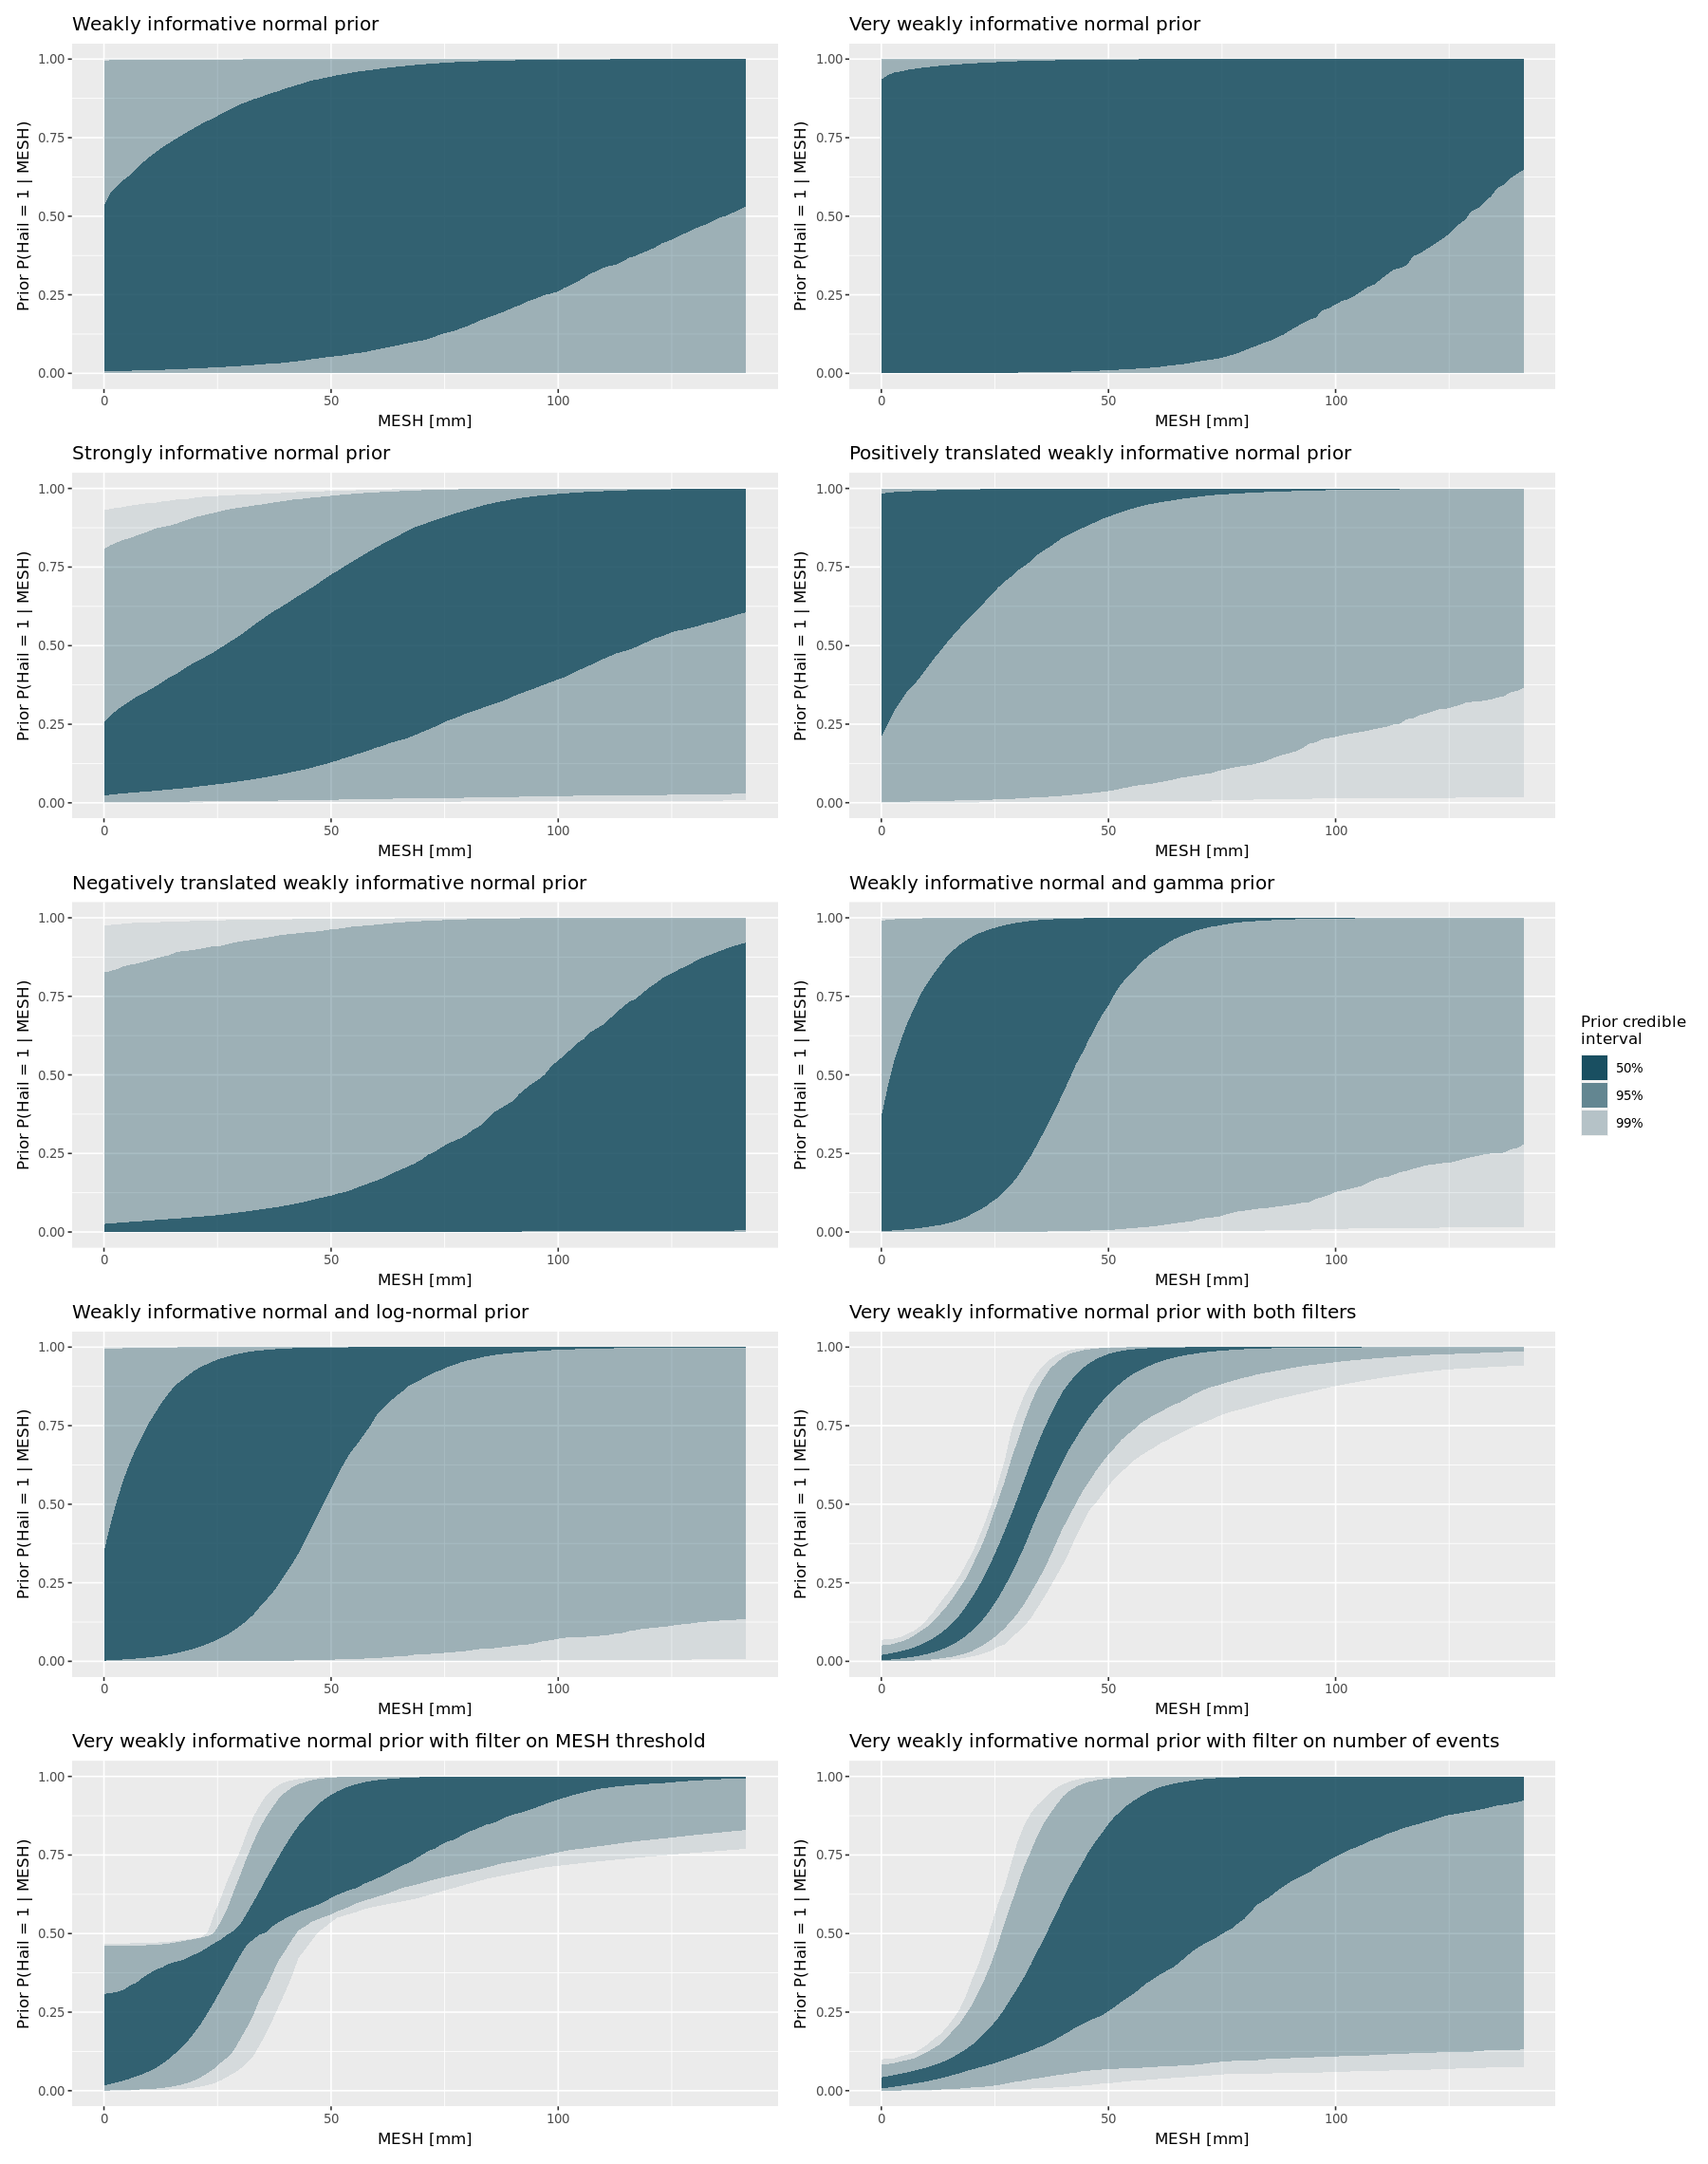

In [9]:
# plot size
options(repr.plot.width = 15, repr.plot.height = 19)

# running through the plot function with modified short title
map(data_for_plot, \(x) generate_prior_plot(x$tibble_to_plot, str_split_1(x$title, ",")[1], x$var)) %>%
  # wrapping into grid
  wrap_plots(guides = "collect", nrow = 5)